#### [Link to GitHub repository](https://github.com/linusghanadan/ml-chesapeake-bay)

## Purpose
In this blog post, I’ll build and compare two deep learning models that predict phosphorus concentration in Chesapeake Bay tidal regions based on the time and location of sample.

## Background
This analysis will focus on phosphorus pollution. Phosphorus, along with nitrogen, are the two major pollutants responsible for algal blooms in the Chesapeake Bay. A 2022 study found that agricultural runoff was the largest source of nutrient pollution, accounting for 48% of nitrogen and 27% of phosphorus in the Chesapeake Bay ([Chesapeake Progress](https://www.chesapeakeprogress.com/clean-water/watershed-implementation-plans)), n.d.). Both phosphorus and nitrogen also get to the Bay as a result of urban and suburban runoff, wastewater treatment plants releasing treated water, and natural sources like runoff from forests and wetlands.

## Data
Yearly water quality data on the Chesapeake Bay’s tidal and non-tidal regions going back to 1984 is publicly available on the Chesapeake Bay Program (CBP) DataHub ([Chesapeake Bay Program DataHub](https://datahub.chesapeakebay.net/FileDownloads), n.d.).

For my analysis, I will be using 2010 to 2019 data collected at 143 different monitoring stations positioned throughout the Chesapeake Bay tidal regions, which includes the mainstem Bay and tributary components. Across the 10 years that we are looking at, we’ll have a total of 43,590 phosphorus observations.

## Data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow import keras

In [3]:
# Create a list of data URLs
excel_urls = [
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2019_CEDR_tidal_data_01jun21.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2018_CEDR_tidal_data_01jun21.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2017_CEDR_tidal_data_11oct18.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2016_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2015_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2014_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2013_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2012_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2011_CEDR_tidal_data_15jun17.xlsx',
    'https://datahub-content.chesapeakebay.net/traditional_annual_tidal_02jun21/2010_CEDR_tidal_data_15jun17.xlsx'
]

# Create an empty list to store data frames
dfs = []

# Loop through each URL, read the Excel file directly into pandas, and append to list of data frames
for url in excel_urls:
    # Get the content of the Excel file
    response = requests.get(url)
    
    # Read the Excel file directly from the content
    wq_data = pd.read_excel(BytesIO(response.content), sheet_name=0)
    dfs.append(wq_data)

# Combine all data frames into a single data frame
wq_data_combined = pd.concat(dfs, ignore_index=True)

## Data exploration

In [346]:
# Wrangle data for relevant column variables, and filter for TP (total phosphorus)
phos_data = wq_data_combined[["SampleDate", "Parameter", "MeasureValue", "Latitude", "Longitude"]]
phos_data = phos_data[phos_data["Parameter"] == "TP"]

phos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43590 entries, 60 to 2484391
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   SampleDate    43590 non-null  datetime64[ns]
 1   Parameter     43590 non-null  object        
 2   MeasureValue  43590 non-null  float64       
 3   Latitude      43590 non-null  float64       
 4   Longitude     43590 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.0+ MB


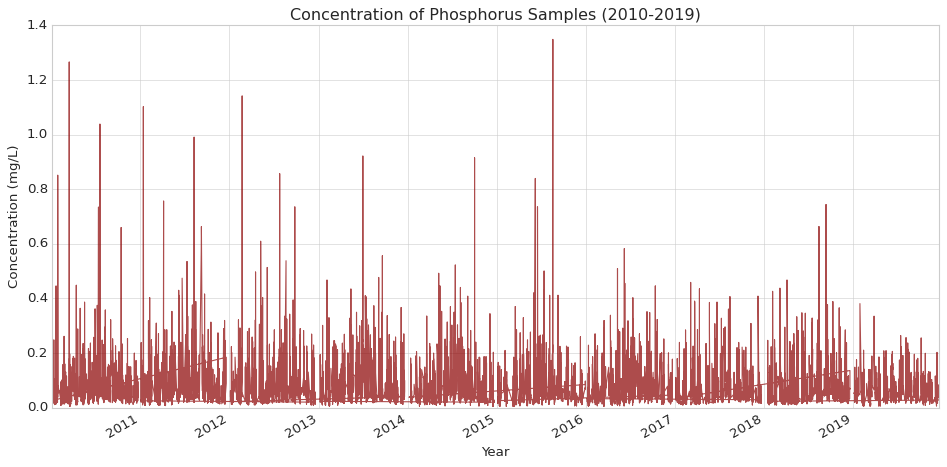

In [347]:
# Initialize figure
plt.figure(figsize=(12, 6))

# Plot phosphorus data
plt.plot(phos_data['SampleDate'], phos_data['MeasureValue'], label='Total Phosphorus (TP)', color='darkred', alpha=0.7)

# Customize the plot
plt.title('Concentration of Phosphorus Samples (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Concentration (mg/L)')

# Rotate and align tick labels
plt.gcf().autofmt_xdate()

# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.show()

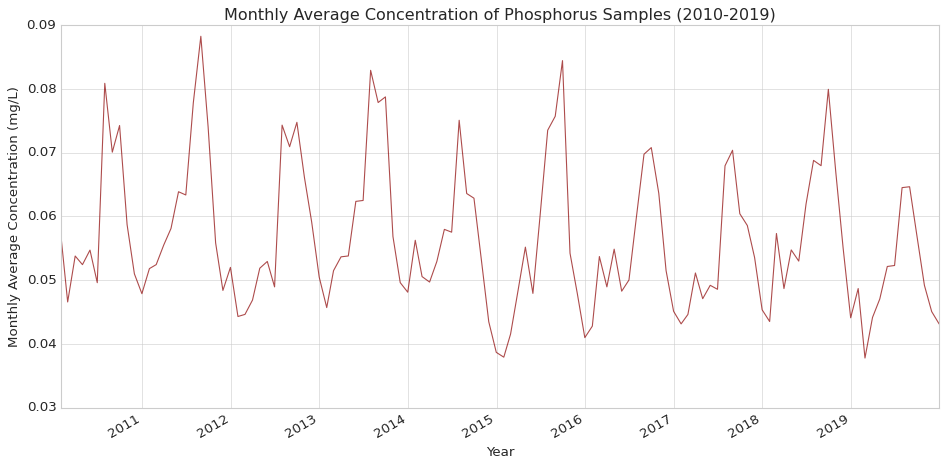

In [348]:
# Resample to monthly frequency and calculate the mean
monthly_avg = phos_data.resample('M').mean()

# Initialize figure
plt.figure(figsize=(12, 6))

# Plot monthly average phosphorus data
plt.plot(monthly_avg.index, monthly_avg['MeasureValue'], color='darkred', alpha=0.7)

# Customize the plot
plt.title('Monthly Average Concentration of Phosphorus Samples (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Monthly Average Concentration (mg/L)')

# Rotate and align tick labels
plt.gcf().autofmt_xdate()

# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.show()


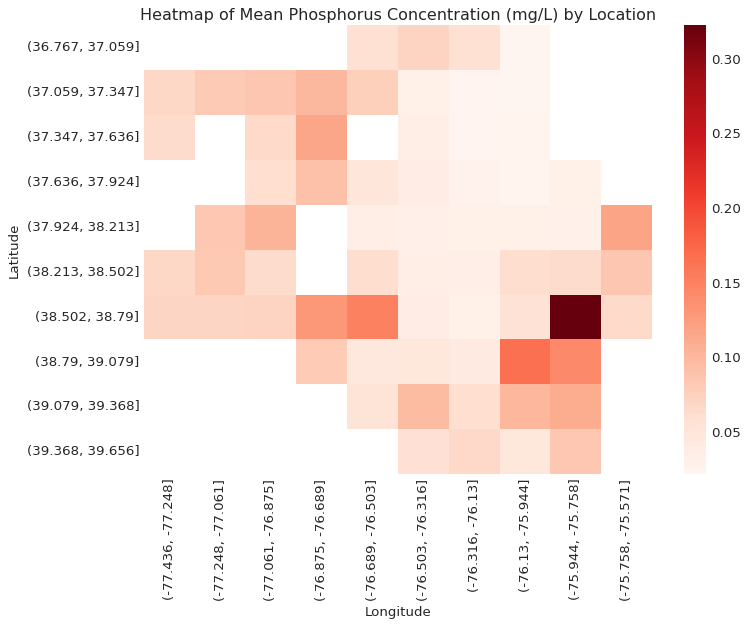

In [349]:
# Bin latitude and longitude into groups
phos_data_copy = pd.DataFrame(phos_data)
phos_data_copy['Latitude Group'] = pd.cut(phos_data['Latitude'], bins=10)
phos_data_copy['Longitude Group'] = pd.cut(phos_data['Longitude'], bins=10)

# Pivot the data to create a heatmap
heatmap_data = phos_data_copy.pivot_table(index='Latitude Group', columns='Longitude Group', values='MeasureValue', aggfunc='mean')

# Initialize the figure
plt.figure(figsize=(10, 8))

# Set style
plt.style.use('seaborn-whitegrid')  # You can choose 'seaborn-dark', 'seaborn-notebook', or any other style

# Plot heatmap
sns.heatmap(heatmap_data, cmap='Reds')

# Customize the plot
plt.title('Heatmap of Mean Phosphorus Concentration (mg/L) by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

## Data pre-processing

In [7]:
# Create numerical feature for days since start date
phos_data['Days'] = (phos_data['SampleDate'] - phos_data['SampleDate'].min()).dt.days

# Prepare features and target
X = phos_data[['Days', 'Latitude', 'Longitude']]
y = phos_data['MeasureValue']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input for RNN (samples, time steps, features)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

## Basic RNN model
A **Recurrent Neural Network (RNN)** is a complex Artificial Neural Network (ANN) architecture that can be applied to sequence prediction for classification and regression tasks (in addition, they are often applied to sequence prediction for text data in generative modeling). Specifically, I will use the **Long Short-Term Memory (LSTM)** network, which many experts consider to be the most useful version of RNNs.

In [352]:
def create_rnn_model(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        keras.layers.LSTM(64),
        keras.layers.Dense(1)
    ])
    return model

# Create the RNN model
rnn_model = create_rnn_model((1, 3))  # (time steps, features)

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse')

# Print model summary
rnn_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 1, 64)             17408     
                                                                 
 lstm_85 (LSTM)              (None, 64)                33024     
                                                                 
 dense_92 (Dense)            (None, 1)                 65        
                                                                 
Total params: 50,497
Trainable params: 50,497
Non-trainable params: 0
_________________________________________________________________


In [353]:
# Train the model
history = rnn_model.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

In [354]:
# Make predictions
rnn_predictions = rnn_model.predict(X_test_rnn).flatten()

# Calculate error metrics
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

273/273 [==============================] - 3s 4ms/step


## Hybrid RNN-MLP model
A **Multilayer Perceptron (MLP)** is a simple and flexible ANN architecture that can be applied to an extremely wide range of predictive classification and regression tasks involving tabular data. A simple MLP for regression tasks could just include two hidden layers: a dense layer with a specialized activation function (e.g., ReLU function), followed by a one-neuron dense layer.

The goal of our analysis is to assess the value of combining a RNN with a MLP for the task of predicting phosphorus concentration, so to add on to our RNN model, we will just add a very simple 16-neuron dense layer with the ReLU activation function before our one-neuron dense layer.

In [355]:
def create_hybrid_model(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        keras.layers.LSTM(64),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)
    ])
    return model

# Create model
hybrid_model = create_hybrid_model((1, 3))  # (time steps, features)

# Compile model
hybrid_model.compile(optimizer='adam', loss='mse')

# Print model summary
hybrid_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 1, 64)             17408     
                                                                 
 lstm_87 (LSTM)              (None, 64)                33024     
                                                                 
 dense_93 (Dense)            (None, 16)                1040      
                                                                 
 dense_94 (Dense)            (None, 1)                 17        
                                                                 
Total params: 51,489
Trainable params: 51,489
Non-trainable params: 0
_________________________________________________________________


In [356]:
# Train the model
history = hybrid_model.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

In [357]:
# Make predictions
hybrid_predictions = hybrid_model.predict(X_test_rnn).flatten()

# Calculate error metrics
hybrid_mae = mean_absolute_error(y_test, hybrid_predictions)
hybrid_mse = mean_squared_error(y_test, hybrid_predictions)
hybrid_rmse = np.sqrt(hybrid_mse)
hybrid_mae

273/273 [==============================] - 2s 4ms/step


## Model comparison

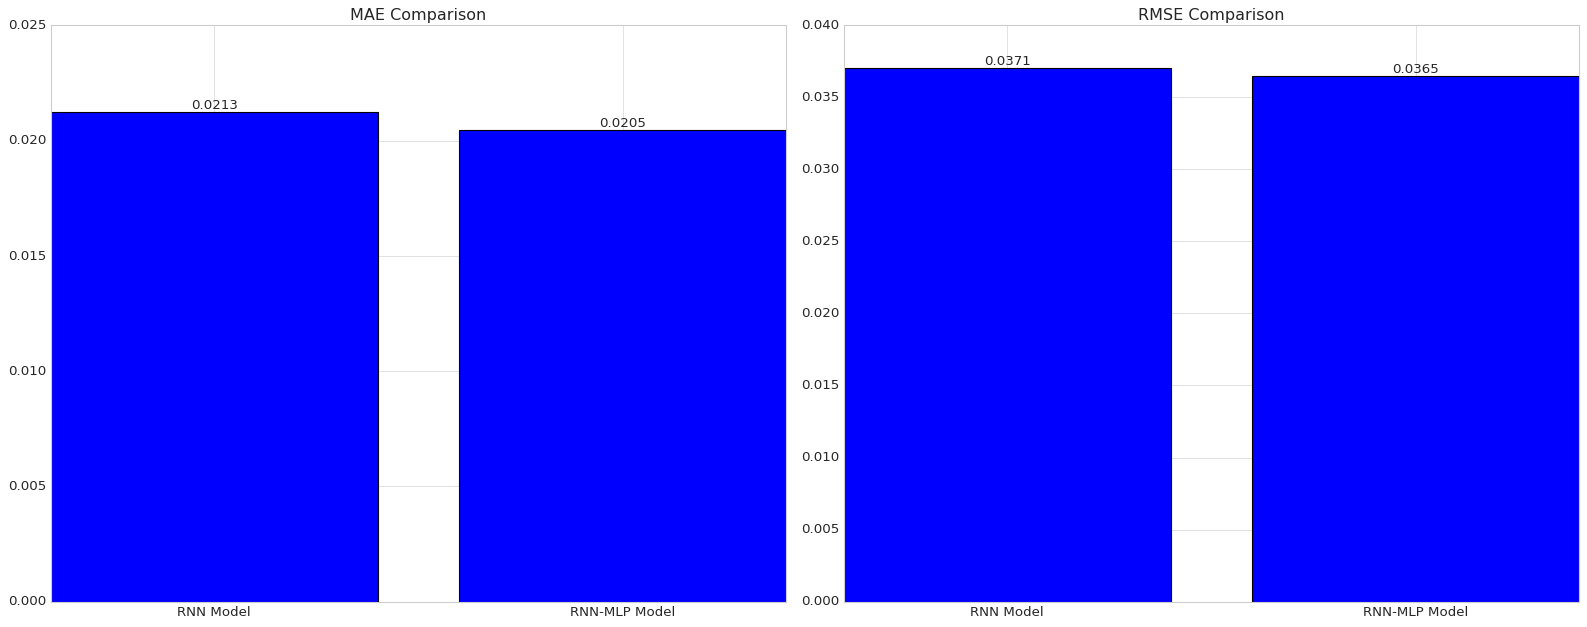

In [366]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for the first model (left subplot)
ax1 = axes[0]

# Compare MAE
bars1 = ax1.bar(['RNN Model', 'RNN-MLP Model'], [rnn_mae, hybrid_mae])
ax1.set_title('MAE Comparison')

# Add text annotations for MAE
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()*3/7, yval, round(yval, 4), va='bottom')  # va='bottom' aligns text at the bottom of the bar

# Plot for the second model (right subplot)
ax2 = axes[1]

# Compare RMSE
bars2 = ax2.bar(['RNN Model', 'RNN-MLP Model'], [rnn_rmse, hybrid_rmse])
ax2.set_title('RMSE Comparison')

# Add text annotations for RMSE
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()*3/7, yval, round(yval, 4), va='bottom')  # va='bottom' aligns text at the bottom of the bar

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


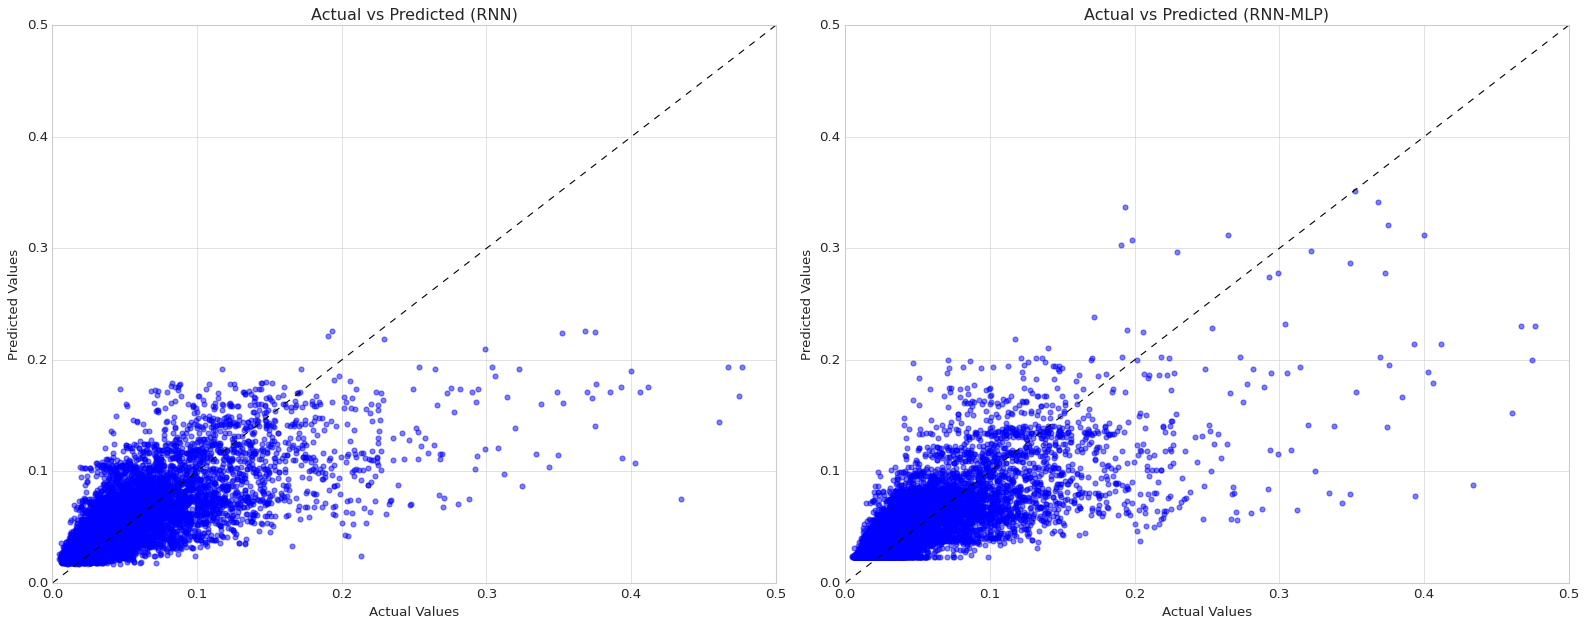

In [359]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for the first model (left subplot)
ax1 = axes[0]

# Add a line y = x
x = np.linspace(0, 1.4, 100)
ax1.plot(x, x, color='black', linestyle='--', linewidth=1)

# Scatter plot for Basic RNN model predictions
ax1.scatter(y_test, rnn_predictions, color='blue', alpha=0.5, label='RNN')

# Set axis labels and title
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Actual vs Predicted (RNN)')

# Set axis limits
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 0.5)

# Plot for the second model (right subplot)
ax2 = axes[1]

# Add a line y = x
ax2.plot(x, x, color='black', linestyle='--', linewidth=1)

# Scatter plot for Hybrid model predictions
ax2.scatter(y_test, hybrid_predictions, color='blue', alpha=0.5, label='RNN-MLP')

# Set axis labels and title
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Actual vs Predicted (RNN-MLP)')

# Set axis limits
ax2.set_xlim(0, 0.5)
ax2.set_ylim(0, 0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Conclusion


From adding an additional 16-neuron dense layer with a ReLU activation function to our LSTM network architecture, we saw a 3.8% decrease in MAE and a 1.6% decrease in RMSE, suggesting that there are potential advantages from using a hybrid RNN-MLP model in this context. Looking at side-by-side scatter plots of actual values and predicted values, it appears the reductions in MAE and RMSE can be attributed to enhanced outlier detection among actual concentration values greater than 0.15 mg/L.

Further analysis would be helpful to see how employing cross-validation to tune for number of ReLU layers and number of neurons per layer (in LSTM layers and ReLU layers) might impact these results. Unfortunetly, I did not have access to an accelerator for this project, so I was unable to conduct an analysis with that level of granularity.